# PN2V Prediction
Please run the `2_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel
from pn2v import gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse actin/'

# Load the test data
dataTest=imread(path+"sample_attempt2.tif")[:,:,:512] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]



### Load the Network and Noise Model

In [3]:
dataName = 'mouseactin'# Use the same name as used in 2_ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
# Load the noiseModel of interest 
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'bootstrap'
nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
net=torch.load(path+"/last_"+namePN2VModel+".net")
try:
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
except:
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     path, torch.Tensor(params['trained_weight']), 
                                                                     n_gaussian=int(nameNoiseModel.split('_')[-3]), 
                                                                     n_coeff=int(nameNoiseModel.split('_')[-2]), min_sigma=200)
    

In [5]:
net=torch.load(path+"/last_"+namePN2VModel+".net")

### Evaluation

image: 0
PSNR input 23.643400849264026
PSNR prior 33.44068789901701
PSNR mse 33.72746605787974
-----------------------------------
image: 1
PSNR input 23.620883803207068
PSNR prior 33.35653931356283
PSNR mse 33.63811013981972
-----------------------------------
image: 2
PSNR input 23.667113469021835
PSNR prior 33.36878033728139
PSNR mse 33.651782091940625
-----------------------------------
image: 3
PSNR input 23.64709110714436
PSNR prior 33.46905644499912
PSNR mse 33.75712527981332
-----------------------------------
image: 4
PSNR input 23.672914919463746
PSNR prior 33.449007431459215
PSNR mse 33.732164813770055
-----------------------------------
image: 5
PSNR input 23.669950605295924
PSNR prior 33.406497061765215
PSNR mse 33.689656344951025
-----------------------------------
image: 6
PSNR input 23.70231487515842
PSNR prior 33.38848098421333
PSNR mse 33.666651688457335
-----------------------------------
image: 7
PSNR input 23.705049534851174
PSNR prior 33.44762994312033
PSNR mse 33

image: 63
PSNR input 23.720689613627076
PSNR prior 33.394932858009675
PSNR mse 33.684414654221264
-----------------------------------
image: 64
PSNR input 23.716027075591573
PSNR prior 33.415565781432186
PSNR mse 33.71227023697644
-----------------------------------
image: 65
PSNR input 23.73440771063101
PSNR prior 33.46494012717105
PSNR mse 33.74635589658885
-----------------------------------
image: 66
PSNR input 23.752612512661457
PSNR prior 33.268019820686206
PSNR mse 33.5551674449199
-----------------------------------
image: 67
PSNR input 23.76459996947784
PSNR prior 33.408096941914344
PSNR mse 33.69365290307684
-----------------------------------
image: 68
PSNR input 23.759235163477868
PSNR prior 33.38910617825043
PSNR mse 33.67391980081264
-----------------------------------
image: 69
PSNR input 23.745309084966966
PSNR prior 33.449223649684
PSNR mse 33.72519598938371
-----------------------------------
image: 70
PSNR input 23.7092400215346
PSNR prior 33.347563666171624
PSNR mse

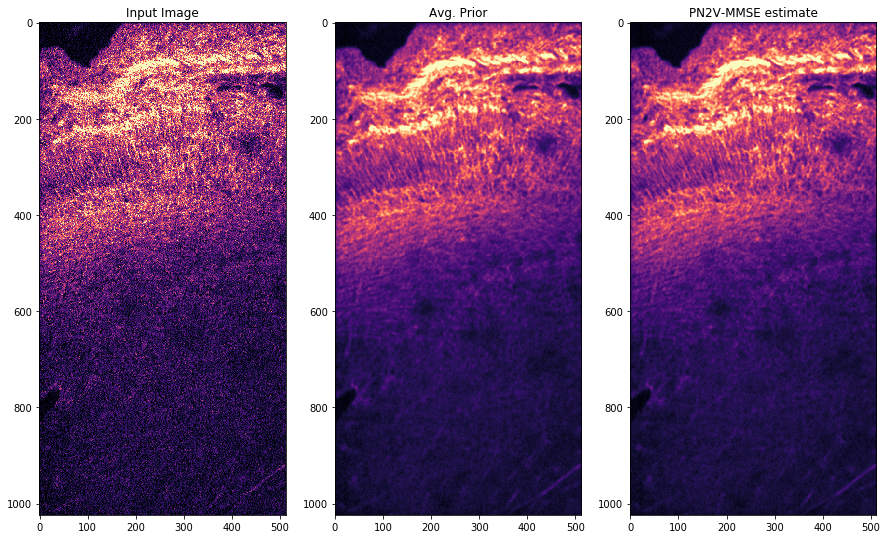

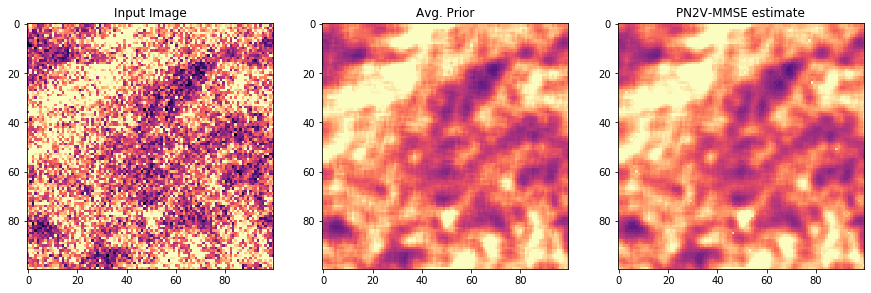

Avg PSNR Prior: 33.41899126461155 +-(2SEM) 0.008594647148877133
Avg PSNR MMSE: 33.703292322331464 +-(2SEM) 0.008751816226429825


In [6]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net, ps=128, overlap=48,
                                             device=device, noiseModel=noiseModel)

    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )